**Прогнозирование оттока клиентов телекоммуникационной компании**

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Составим план работы.**

1. Загрузка библиотек, знакомство с данными.

Необходимо посмотреть, каким объемом данных мы распологаем, какие есть пересекающиеся поля в разных файлах, изучить типы данных, узнать, есть ли пропуски в данных и сколько их.

2. Объединение таблиц, предобработка данных.

Работать с несколткими таблицами неудобно, их следует объединить. Если будут обнаружены проблемы в данных (не верные типы данных, пропуски и т.д.), их необходимо обработать.

3. Работа с признаками и тагетами.

В этом разделе необходимо определить, какие признаки будем использовать для обучения моделей. Техникой OHE категориальные признаки переведём в численные. Также поступим с целевыми признаками: есть дата ухода клиента - значение тагета равно 1, нет - 0. После кодирования признаков проведем разбиение данных на обучающую, валидационную тестовую выборки.

4. Построение моделей.

Построим разные модели: LogisticRegression, DecisionTreeClassifier, RandomForestClassifier. Применим кроссвалидацию, изменим значение порога и посмотрим, какими станут метрики на валидационной выборке, подберем оптимальные гиперпараметры.

5. Тестирование модели.

Получим значения метрик на тестовой выборке.

**1. Загрузка библиотек и файлов, знакомство с данными**

In [1]:
# Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier

from tqdm import notebook

In [2]:
# Загрузим исходные таблицы
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [3]:
# Объединим исходные таблицы в одну
df = (contract
      .merge(personal, on='customerID', how='left')
      .merge(phone, on='customerID', how='left')
      .merge(internet, on='customerID', how='left'))

# Приведем названия столбцов к нижнему регистру
df.columns = df.columns.str.lower()

# Посмотрим, что получилось
df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
customerid          7043 non-null object
begindate           7043 non-null object
enddate             7043 non-null object
type                7043 non-null object
paperlessbilling    7043 non-null object
paymentmethod       7043 non-null object
monthlycharges      7043 non-null float64
totalcharges        7043 non-null object
gender              7043 non-null object
seniorcitizen       7043 non-null int64
partner             7043 non-null object
dependents          7043 non-null object
multiplelines       6361 non-null object
internetservice     5517 non-null object
onlinesecurity      5517 non-null object
onlinebackup        5517 non-null object
deviceprotection    5517 non-null object
techsupport         5517 non-null object
streamingtv         5517 non-null object
streamingmovies     5517 non-null object
dtypes: float64(1), int64(1), object(18)
memory usage: 1.1+ MB


,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No


In [4]:
# Найдем строки, где в столбце totalcharges стоят пробелы
df[df['totalcharges'] == ' ']

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,NaN,DSL,Yes,No,Yes,Yes,Yes,No
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,Male,0,No,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,Female,0,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,Male,0,Yes,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,Yes,NaN,DSL,Yes,Yes,Yes,Yes,Yes,No
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,Male,0,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,Male,0,Yes,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,Female,0,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,Female,0,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No


**Выводы**

Мы получили данные по 7043 клиентам. Отдельные столбцы содержат нулевые значения. Изучив полученные данные мы видим ряд проблем, которые требуют устранения: данные из столбца totalcharges имеют тип object, 11 строк вместо значений содержат пробелы. Это скорее всего новые клиенты, которые ни разу не заплатили.

**2. Работа с признаками и таргетом**

In [5]:
# Посчитаем сколько дней клиент пользовался услугами оператора
df['days'] = (pd.to_datetime(df.enddate.replace({'No': '2020-02-01'}))
                  - pd.to_datetime(df.begindate)).dt.days

# Разметим, расторг клиент контракт, или нет
df['on_off'] = df.enddate.apply([lambda x: 0 if x == 'No' else 1])

# Разметим, подключена ли клиенту услуга многоканальной телефонной линии
df['phone'] = df.multiplelines.apply([lambda x: 0 if pd.isna(x) else 1])

# Разметим, подключен ли к клиент к Интернету
df['internet'] = df.internetservice.apply([lambda x: 0 if pd.isna(x) else 1])

# Заполним столбец totalcharges для новых клиентов значениями из столбца monthlycharges
df.totalcharges = df.totalcharges.replace(' ', np.nan).astype('float').fillna(df.monthlycharges)

# Заполним пропуски в данных
values = dict(multiplelines='No', internetservice='No',
              onlinesecurity='No', onlinebackup='No',
              deviceprotection='No', techsupport='No',
              streamingtv='No', streamingmovies='No')

df.fillna(value='values', inplace=True)

# Посмотрим, что получилось
df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
customerid          7043 non-null object
begindate           7043 non-null object
enddate             7043 non-null object
type                7043 non-null object
paperlessbilling    7043 non-null object
paymentmethod       7043 non-null object
monthlycharges      7043 non-null float64
totalcharges        7043 non-null float64
gender              7043 non-null object
seniorcitizen       7043 non-null int64
partner             7043 non-null object
dependents          7043 non-null object
multiplelines       7043 non-null object
internetservice     7043 non-null object
onlinesecurity      7043 non-null object
onlinebackup        7043 non-null object
deviceprotection    7043 non-null object
techsupport         7043 non-null object
streamingtv         7043 non-null object
streamingmovies     7043 non-null object
days                7043 non-null int64
on_off              7043 non-nul

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,...,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,days,on_off,phone,internet
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,No,Yes,No,No,No,No,31,0,0,1
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,...,Yes,No,Yes,No,No,No,1036,0,1,1
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,Yes,Yes,No,No,No,No,61,1,1,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,Yes,No,Yes,Yes,No,No,1371,0,0,1
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,No,No,No,No,No,No,61,1,1,1


In [6]:
# Построим матрицу корреляции
print(df.corr())

                monthlycharges  totalcharges  seniorcitizen      days  \
monthlycharges        1.000000      0.651182       0.220173  0.247754   
totalcharges          0.651182      1.000000       0.102997  0.826095   
seniorcitizen         0.220173      0.102997       1.000000  0.016514   
days                  0.247754      0.826095       0.016514  1.000000   
on_off                0.193356     -0.198347       0.150889 -0.352673   
phone                 0.247398      0.113203       0.008576  0.008446   
internet              0.763557      0.375229       0.182742  0.038951   

                  on_off     phone  internet  
monthlycharges  0.193356  0.247398  0.763557  
totalcharges   -0.198347  0.113203  0.375229  
seniorcitizen   0.150889  0.008576  0.182742  
days           -0.352673  0.008446  0.038951  
on_off          1.000000  0.011942  0.227890  
phone           0.011942  1.000000 -0.172209  
internet        0.227890 -0.172209  1.000000  


In [7]:
# Удалим ненужные для обучения столбцы
drop = ['customerid', 'begindate', 'enddate', 'on_off', 'internet', 'phone', 'totalcharges']

# Техникой OHE категориальные признаки переведём в численные
X = pd.get_dummies(df.drop(drop, axis=1), drop_first=True)

# Целевой признак
y = df['on_off']

# Разобъем данные обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=1234)

**Выводы**

В данном разделе мы провели предобработку данных, создали новые столбцы, необходимые для обучения, удалили ненужные. Из полученной таблицы выделили целевой признак, данные разбили на обучающую и тестовую выборки.

Построив матрицу корреляции, мы видим существенную зависимость двух факторов: days и totalcharges. Действительно, чем больше дней у клиента действует контракт, тем больше денег в сумме он заплатил. Удалим признак totalcharges.

**3. Выбор лучшей модели**

In [8]:
# Сформируем перечень моделей, которые будут обучены
models = [
    ('Logistic Regression', LogisticRegression(random_state=1234)),
    ('Random Forest', RandomForestClassifier(random_state=1234)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=1234)),
    ('Stochastic Gradient Descent', SGDClassifier(random_state=1234)),
    ('Multi-layer Perceptron', MLPClassifier(hidden_layer_sizes=(10, 5), random_state=1234)),
]

scoring = ('roc_auc', 'accuracy')
results = pd.DataFrame()

# Проведем выбор лучшей модели по двум метрикам
for name, model in notebook.tqdm(models):
    pipe = Pipeline([('scaler', StandardScaler()), ('clf', model)])
    cval = cross_validate(pipe, X_train, y_train, scoring=scoring, n_jobs=-1)
    cval.update(model=name)

    results = pd.concat([results, pd.DataFrame(cval)])

# Выведем результаты
results = results.groupby('model').mean().sort_values(by='test_roc_auc', ascending=False)
results.index.name = 'Модель'
results.columns = ['Обучение (сек)', 'Предсказание (сек)',
                   'Среднее ROC-AUC на валидации', 'Среднее Accuracy на валидации']
display(results)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in 

,Обучение (сек),Предсказание (сек),Среднее ROC-AUC на валидации,Среднее Accuracy на валидации
Модель,,,,
Gradient Boosting,0.483366,0.014486,0.886121,0.835100
Logistic Regression,0.161780,0.043805,0.847773,0.804809
Multi-layer Perceptron,2.553393,0.044863,0.833812,0.791555
Stochastic Gradient Descent,0.131767,0.054381,0.820965,0.774704
Random Forest,0.089800,0.015948,0.809814,0.793448


**Выводы**

На данном этапе работы мы определили модель которая показала наибольшие метрики ROC-AUC и Accuracy. Это модель Gradient Boosting. Проверим ее на тестовых данных, а также запустим более продвинутую модель этого вида CatBoostClassifier.

**4. Тестирование модели**

In [9]:
# Проверим работу модели GradientBoostingClassifier на тестовой выборке
model = models[2][1]
model.fit(X_train, y_train)
predict = model.predict(X_test)
predict_proba = model.predict_proba(X_test)[:, 1]

print('ROC-AUC на тестовой выборке: %.3f' % roc_auc_score(y_test, predict_proba))
print('Accuracy на тестовой выборке: %.3f ' % accuracy_score(y_test, predict))

ROC-AUC на тестовой выборке: 0.872
Accuracy на тестовой выборке: 0.841 


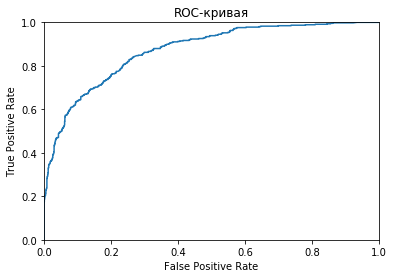

In [10]:
# Построим ROC-кривую
fpr, tpr, thresholds = roc_curve(y_test, predict_proba)  

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 

In [11]:
# Проверим работу модели CatBoostClassifier на тестовой выборке
catboost = CatBoostClassifier(
    iterations=1100,
    learning_rate=0.1,
    depth=4,
    verbose=200,
    loss_function='CrossEntropy',
    eval_metric='AUC',
    random_state=1234
)
catboost.fit(
    X_train, y_train,
    eval_set=(X_test, y_test)
)

predict = catboost.predict(X_test)
predict_proba = catboost.predict_proba(X_test)[:, 1]

print('ROC-AUC на тестовой выборке: %.3f' % roc_auc_score(y_test, predict_proba))
print('Accuracy на тестовой выборке: %.3f ' % accuracy_score(y_test, predict))

0:	test: 0.7946975	best: 0.7946975 (0)	total: 57.8ms	remaining: 1m 3s
200:	test: 0.8921363	best: 0.8921363 (200)	total: 5.26s	remaining: 23.5s
400:	test: 0.9097626	best: 0.9098180 (398)	total: 10s	remaining: 17.5s
600:	test: 0.9169816	best: 0.9171595 (596)	total: 16.5s	remaining: 13.7s
800:	test: 0.9186798	best: 0.9186999 (799)	total: 21.2s	remaining: 7.9s
1000:	test: 0.9189466	best: 0.9193594 (812)	total: 26.1s	remaining: 2.58s
1099:	test: 0.9196178	best: 0.9199350 (1091)	total: 28.5s	remaining: 0us

bestTest = 0.9199349586
bestIteration = 1091

Shrink model to first 1092 iterations.
ROC-AUC на тестовой выборке: 0.920
Accuracy на тестовой выборке: 0.880 


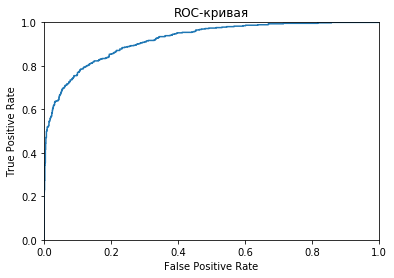

In [12]:
# Построим ROC-кривую
fpr, tpr, thresholds = roc_curve(y_test, predict_proba)  

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 

**Выводы**

Модели GradientBoostingClassifier и CatBoostClassifier показали высокие значения метрики ROC-AUC на тестовой выборке: 0.872 и 0.920 соответственно. Время обучения моделей и формирования прогнозов получилось незначительным. Таким образом, модели могут быть применены для прогнозирования перехода клиентов к другим операторам.

**Общий вывод**

Нам были предоставлены данные о клентах оператора связи, у которых действует контракт и которые ушли от данного оператора. Нашей задачей было сформировать модель для прогнозирования ухода клиента, чтобы попытаться его удержать в компании путем предоставления скидки или промокода. 

Мы проведи предобработку данных, разделили их на обучающую и тестовую выборки. Далее выбрали модели, которые показали наилучший результат на тестовой выборке.

Теперь компания может увеличивать свою прибыль за счет снижения оттока клиентов.